# Portfolio optimization


## Introduction 

We consider the portfolio optimization problem, where an investor aims to allocate capital among $N$ assets within a single period. Portfolio optimization is a fundamental concept in finance that focuses on balancing risk and return, The objective is to determine the optimal weights to assign to each asset in the portfolio.

![Example](pfo.png "Example")

This illustration shows the percentage of capital to invest in each asset.

## Notebook installation requirements 

In [1]:
import subprocess
import sys

def install_requirements():
    try:
        with open('requirements.txt') as f:
            packages = f.read().splitlines()
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'])
        print("All packages have been successfully installed.")
    except Exception as e:
        print(f"An error occurred while installing the packages: {e}")

install_requirements()

All packages have been successfully installed.


## Problem description

There are multiple variants of portfolio optimization problems. Let's start with the most fundamental one - the Markovitz model - which minimizes the total variance under a fixed return.

**Input**

* $N \in \mathbb{N}$ assets; for each asset $j$, $j = 1, \dots, N$, its expected return $M_j \in \mathbb{R}^+$
* A desired return $R \in \mathbb{R}^+$
* For each pair of assets $(i, j)$, $i = 1, \dots, N$, $j = 1, \dots, N$, its covariance $C_i^j \in \mathbb{R}^+$

**Problem**: find for each asset, the proportion of the capital invested in it, such that the desired return is met.

**Objective**: minimize the risk (total variance)
$$
w^T C w
$$
where $w$ represents the vector of allocations

## Mathematical model 

**Variables**:

* $w_i \in [0,1]$,  $i = 1, \dots, N$: proportion of capital invested in asset $i$ (weights to assign to each asset in the portfolio)

**Objective**:
* Minimize the risk (total variance)
$$
\sum_{i=1}^N{\sum_{j=1}^N{C_i^jw_iw_j}}
$$

**Constraints**:

* Expected return
$$
\sum_{i=1}^N{w_iM_i}\geq R
$$

* Sum of proportions equals to 1 
$$
\sum_{i=1}^N{w_i}= 1
$$

The model has the following properties:

* Continuous variables only
* Quadratic objective
* Convex (since a covariance matrix is positive semi-definite)
* Therefore, it is a convex QP

We solve the problem with Artelys Knitro using the Pyomo modeler.

## Input

We retrieve realistic input data from http://www.nasdaq.com/

In [2]:
nb_assets = 10

expected_returns = [8.68097, -6.08624, -66.84089, -69.02419, -0.61631, 10.46047, 7.63278, 20.49615, -0.257636, 19.25747]

cov_matrix = [[1.75, 0.38, 0.54, 0.63, -0.14, 0.29, -0.15, -0.19, 0.06, 0.10],
[0.38, 1.74, 0.75, 2.13, -0.14, 0.30, 0.86, 0.24, 0.28, 0.47],
[0.54, 0.75, 6.85, 0.31, -0.01, 0.84, -0.14, 0.71, 0.50, 0.95],
[0.63, 2.13, 0.31, 10.31, 0.48, 0.27, 0.23, 0.50, -0.02, 0.47],
[-0.14, -0.14, -0.01, 0.48, 1.24, -0.02, 0.12, 0.15, -0.10, 0.46],
[0.29, 0.30, 0.84, 0.27, -0.02, 1.08, 0.54, 0.38, 0.54, 0.75],
[-0.15, 0.86, -0.14, 0.23, 0.12, 0.54, 0.97, 0.49, 0.44, 0.60],
[-0.19, 0.24, 0.71, 0.50, 0.15, 0.38, 0.49, 2.35, 0.46, 0.86],
[0.06, 0.28, 0.50, -0.02, -0.10, 0.54, 0.44, 0.46, 0.84, 0.37],
[0.10, 0.47, 0.95, 0.47, 0.46, 0.75, 0.60, 0.86, 0.37, 3.16]]

desired_return = 10

assets_names = [
    "Facebook",
    "Intel",
    "Frontier",
    "Micron",
    "Apple",
    "Qualcomm",
    "Sirius",
    "App. Mat.",
    "Cisco",
    "Yahoo"
]

## Pyomo model

Let's write the model with the modeler Pyomo.

In [3]:
import pyomo.environ as pyo

def build_model(nb_assets, expected_returns, cov_matrix, desired_return):
    model = pyo.ConcreteModel()

    ####################
    # Create variables #
    ####################

    model.N = pyo.RangeSet(0, nb_assets - 1)
    model.w = pyo.Var(model.N, within=pyo.NonNegativeReals)

    #############
    # Objective #
    #############

    model.objective = pyo.Objective(
        expr=pyo.quicksum(
            pyo.quicksum(cov_matrix[i][j] * model.w[i] * model.w[j] for j in model.N)
            for i in model.N),
        sense=pyo.minimize)

    ###############
    # Constraints #
    ###############

    def weight_constraint_rule(model):
        return sum(model.w[i] for i in model.N) == 1
    model.weight_constraint = pyo.Constraint(rule=weight_constraint_rule)

    def link_constraint_rule(model, i):
        return sum(model.w[i]*expected_returns[i] for i in model.N) >= desired_return
    model.link_constraint = pyo.Constraint(model.N, rule=link_constraint_rule)

    return model

In [4]:
# Build the model
model = build_model(nb_assets, expected_returns, cov_matrix, desired_return)

# Solve the model
solver = pyo.SolverFactory('knitroampl')  
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

Knitro presolve eliminated 0 variables and 9 constraints.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a convex QP.
Knitro running advanced initialization strategy specified by initpt_strategy.

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Minimize
Objective type:  quadratic
Number of variables:                                 10 (          10)
    bounded below only:                              10 (          10)
    bounded above only:                               0 (           0)
    bounded below and above:                          0 (           0)
    fixed:                                            0 (           0)
    free:                                             0 (           0)
Num

## Output visualization 

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def draw_combined_charts(model, desired_return, assets_names):
    portfolio_weights_bar = [pyo.value(model.w[j]) for j in model.N]
    portfolio_weights_pie = [pyo.value(model.w[j]) for j in model.N if pyo.value(model.w[j]) > 0.01]
    selected_assets_bar = [assets_names[j] for j in model.N]
    selected_assets_pie = [assets_names[j] for j in model.N if pyo.value(model.w[j]) > 0.01]

    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

    asset_color_map = {asset: colors[i % len(colors)] for i, asset in enumerate(assets_names)}

    bar_colors = [asset_color_map[asset] for asset in selected_assets_bar]
    pie_colors = [asset_color_map[asset] for asset in selected_assets_pie]

    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.5, 0.5],
        subplot_titles=("Bar chart", "Pie chart"),
        specs=[[{"type": "xy"}, {"type": "domain"}]]
    )

    # Bar chart
    fig.add_trace(
        go.Bar(
            x=selected_assets_bar,
            y=portfolio_weights_bar,
            text=[f'{weight:.2f}' for weight in portfolio_weights_bar],
            textposition='auto',
            marker=dict(color=bar_colors),  
            opacity=0.8,
            name='Bar Chart',
            showlegend=False
        ),
        row=1, col=1
    )

    # Pie chart
    fig.add_trace(
        go.Pie(
            labels=selected_assets_pie,
            values=portfolio_weights_pie,
            textinfo='label+percent',
            hoverinfo='label+value+percent',
            marker=dict(colors=pie_colors, line=dict(color='#000000', width=2)),
            opacity=0.8,
            name='Pie Chart'
        ),
        row=1, col=2
    )

    fig.update_layout(
        title=f"Knitro solution for a desired return of {desired_return}",
        xaxis_title='Assets',
        yaxis_title='Weight',
        height=600, 
        width=1000, 
    )

    fig.show("png")

    print(f"The total variance is {round(model.objective(), 2)} for a desired return of {desired_return}")

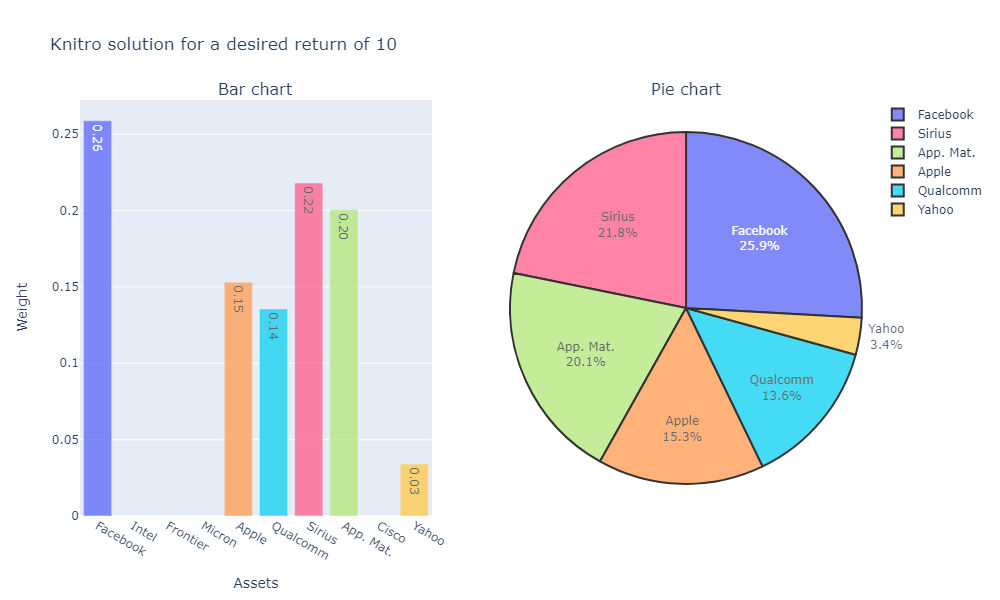

The total variance is 0.43 for a desired return of 10


In [6]:
draw_combined_charts(model, desired_return, assets_names)

Here for a desired return of 10, it seems better to diversify to reduce the portfolio risk.

## Optimization considering various desired returns

In the previous section, we considered a single fixed return. Now let's consider the optimization for different levels of return.

In [7]:
#List of desired returns 
desired_returns = [5, 7.5, 10, 15]

models = []
solver = pyo.SolverFactory('knitroampl')

for desired_return in desired_returns:
    model = build_model(nb_assets, expected_returns, cov_matrix, desired_return)
    results = solver.solve(model)
    models.append(model)


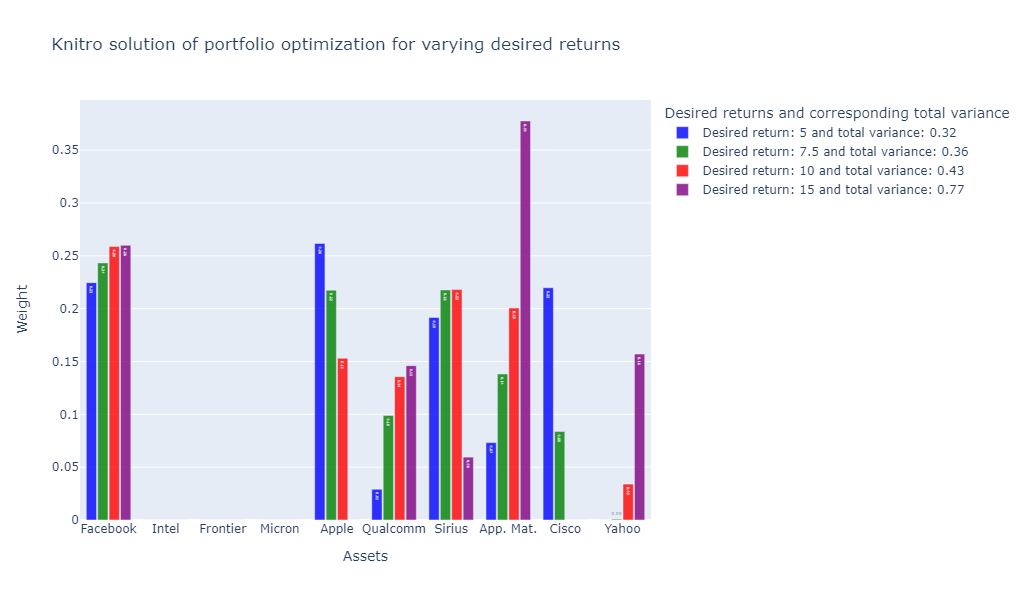

In [8]:
# Improve visualisation for various desired returns
def draw_figures(models, desired_returns, asset_names, title_name):
    fig = go.Figure()
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']  

    for i, model in enumerate(models):
        portfolio_weights = [pyo.value(model.w[j]) for j in model.N]
        selected_assets = [asset_names[j] for j in model.N]
        
        fig.add_trace(go.Bar(
            x=selected_assets,
            y=portfolio_weights,
            name=f'Desired return: {desired_returns[i]} and total variance: {round(model.objective(),2)}',
            text=[f'{weight:.2f}' for weight in portfolio_weights],
            textposition='auto',
            marker_color=colors[i % len(colors)],
            opacity=0.8,
        ))

    fig.update_layout(
        title= title_name,
        xaxis_title='Assets',
        yaxis_title='Weight',
        xaxis=dict(
            tickmode='array',
            tickvals=selected_assets,
            ticktext=[asset_names[j] for j in model.N]  # Utiliser les noms des actifs pour les labels
        ),
        bargap=0.2,  
        bargroupgap=0.1,
        barmode='group', 
        legend_title_text='Desired returns and corresponding total variance',  
    )

    fig.update_layout(autosize=False, width=1024, height=600)
    
    fig.show("png")

draw_figures(models, desired_returns, assets_names, 'Knitro solution of portfolio optimization for varying desired returns')

Here, we can observe the different assets and their weights based on the desired return. We notice that for low returns, it is advantageous to diversify the assets in which to allocate parts of the portfolio to minimize variance and thus minimize risks. On the other hand, as we aim for higher returns (and consequently accept higher risks), we end up investing on the asset that yields the most. However, the risk increases.

## Taking into account diversification 

In portfolio optimization, diversification is a critical principle used to reduce risk by allocating investments among various financial assets, industries, and other categories. Diversification has multiple benefits:

1. **Risk Reduction**: Diversification helps in spreading risk across different assets, reducing the impact of any single asset's poor performance on the overall portfolio.

2. **Control Over Portfolio Composition**: By setting bounds on asset weights and limiting the number of assets, investors can ensure that the portfolio remains manageable and aligned with investment objectives.

3. **Improved Returns**: A well-diversified portfolio can improve the risk-adjusted returns by taking advantage of the benefits of diversification without excessive exposure to any single asset.

In this section, we exhibit two ways to take diversification into account.

### Diversification constraints

For each asset in the portfolio, we define a lower bound $L_i$ and an upper bound $U_i$ on the weight $w_i$:

$$
\forall i = 1, \dots, N \quad L_i \leq w_i \leq U_i
$$

where:
- $w_i$ is the weight of asset $i$ in the portfolio.
- $L_i$ is the minimum allowable weight for asset $i$.
- $U_i$ is the maximum allowable weight for asset $i$.

This constraint ensures that the weight of each asset remains within a specified range, promoting diversification by preventing over-concentration in any single asset.

### Cardinality constraints

To further control the diversification, we introduce a cardinality constraint to ensure that exactly $K$ assets are selected in the portfolio. For this, we introduce a new set of binary variables:

* $x_i \in \{0,1\}$, $i = 1, \dots, N$: $x_i = 1$ iff asset $i$ is selected in the portfolio.

To link these variables with the $w_i$ variables, we need the following constraints:

$$
\forall i = 1, \dots, N \qquad w_i \leq x_i
$$

These constraints ensures that if $w_i$ is non-null, then $x_i$ takes value $1$.

Then, the cardinality constraint can be expressed as:

$$
\sum_{i=1}^N x_i = K
$$

where:
- $x_i = 1$ if asset $i$ is included in the portfolio.
- $x_i = 0$ if asset $i$ is not included in the portfolio.
- $K$ is the desired number of assets in the portfolio.

### Combining diversification and cardinality constraints

The weight constraints and the cardinality constraint together ensure that the portfolio is not only diversified but also limited to a specific number of assets. If both constraints are used, the diversification constraints and the linking constraints between $x_i$ and $w_i$ can be merged into:

$$
\forall i = 1, \dots, N \qquad L_i x_i \leq w_i \leq U_i x_i
$$

This ensures that if an asset $i$ is not selected $x_i = 0$, its weight $w_i$ will be zero. If an asset is selected $x_i = 1$, its weight will lie between $L_i$ and $U_i$.

Now let's implement these constraints into the model.

### Input data

We need to specify additional inputs for these extensions.

In [9]:
# Additional inputs for diversification
L = [0.05, 0.05, 0.06, 0.07, 0.06, 0.05, 0.06, 0.07, 0.05, 0.06]
U =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
K = 3

### Pyomo model

In [10]:
def diversification_extended_model(model,L,U,K):

    # New variable
    model.x = pyo.Var(model.N, within=pyo.Binary)

    # New constraints

    def diversification_lower_constraint_rule(model,i):
        return L[i]*model.x[i] <= model.w[i]
    model.diversification_lower_constraint = pyo.Constraint(model.N, rule=diversification_lower_constraint_rule)

    def diversification_upper_constraint_rule(model,i):
        return model.w[i] <= U[i]*model.x[i]
    model.diversification_upper_constraint = pyo.Constraint(model.N, rule=diversification_upper_constraint_rule)

    def cardinality_nb_assets_constraint_rule(model):
        return sum(model.x[i] for i in model.N) == 3
    model.cardinality_nb_assets_constraint = pyo.Constraint(rule=cardinality_nb_assets_constraint_rule)

models_with_diversifications = []
solver = pyo.SolverFactory('knitroampl')

for desired_return in desired_returns:
    model = build_model(nb_assets, expected_returns, cov_matrix, desired_return)
    diversification_extended_model(model,L,U,K)
    results = solver.solve(model)
    models_with_diversifications.append(model)

### Comparative analysis of models with and without diversification and cardinality

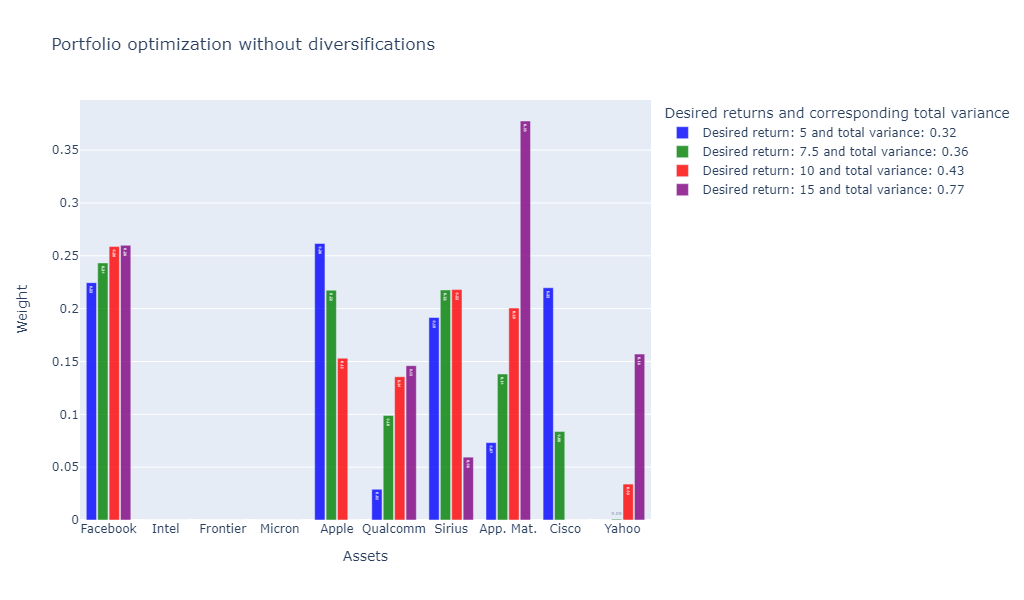

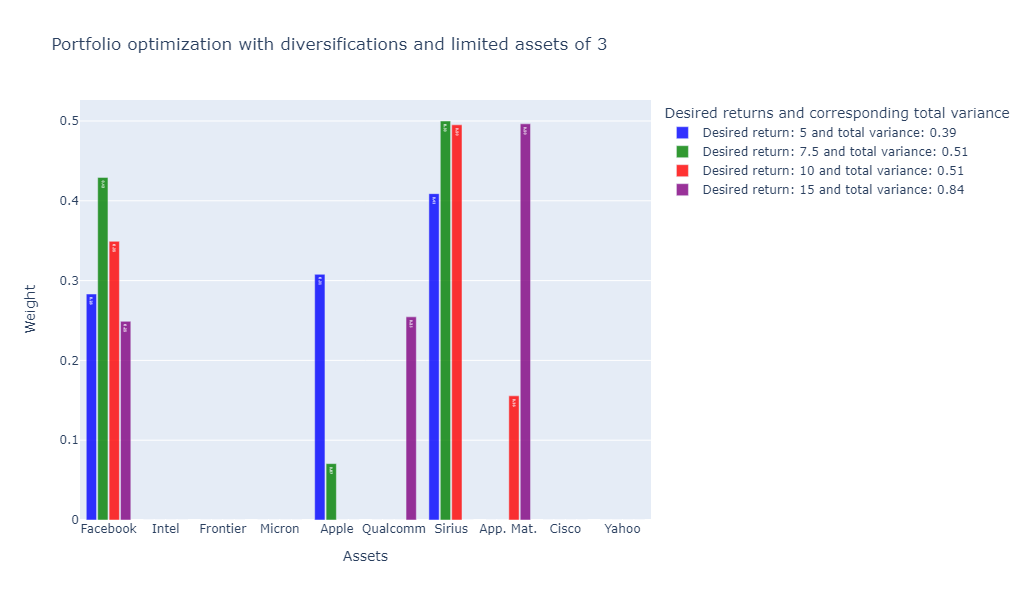

In [11]:
draw_figures(models, desired_returns, assets_names, 'Portfolio optimization without diversifications')
draw_figures(models_with_diversifications, desired_returns, assets_names, 'Portfolio optimization with diversifications and limited assets of 3')

By incorporating extensions related to diversification and cardinality constraints, some assets may no longer be included in the portfolio, while others may see their weights increase. This occurs because such constraints can limit the number of assets selected and enforce a more concentrated allocation, thereby intensifying the focus on a smaller set of high-performing assets.

## Taking into account transaction costs 

Rebalancing a portfolio involves buying and selling securities to adjust its composition, leading to turnover. While the basic Markowitz model assumes there are no trading costs, in practice, turnover incurs expenses.  
There are 2 kinds of transaction costs:  

- **Fixed costs** which represent commissions or transfer fees
- **Variable costs** which depend on the transaction volume, representing costs such as market impact or bid/ask spread, for example.

    

In the variant considered in this section, the objective is to maximize the return and the maximum variance is set as a constraint. To make the model more meaningful, we consider that a proportion of the capital is already invested in some assets.

### Problem description

**Input**:

* $N \in \mathbb{N}$: number of assets 
* $W^0_i \in \mathbb{R}^+$, $i = 1, \dots, N$: fraction of the portfolio value already invested in asset $i$.
* $\Gamma \in \mathbb{R}^+$: limited risk level
* $M_i \in \mathbb{R}^+$, $i = 1, \dots, N$: expected return of asset $i$
* $F_i \in \mathbb{R}^+$, $i = 1, \dots, N$: fixed cost if buying asset $i$
* $V_i \in \mathbb{R}^+$, $i = 1, \dots, N$: variable factor cost when buying asset $i$

**Problem**: find for each asset, the proportion of the capital invested in it, such that the allowed risk level is not exceeded.

**Objective**: maximum the total return

### Mathematic model

**Variables**:

* $w_i \in [0,1]$, $i = 1, \dots, N$: proportion of the capital allocated to asset $i$
* $x_i \in \{0,1\}$, $i = 1, \dots, N$: $x_i = 1$ iff asset $i$ is selected in the portfolio

We need two additional sets of variables to model the absolute value $| w_i - {W_0}_i |$ representing the proportion of the  captial moved from asset $i$ (bought or sold):
* $z^+_i \in [0,1]$, $i = 1, \dots, N$: positive part of $w_i - {W_0}_i$
* $z^-_i \in [0,1]$, $i = 1, \dots, N$: negative part of $w_i - {W_0}_i$

**Objective**:

* Maximize the return

$$
\sum_{i=1}^N{M_i w_i}
$$

**Constraints**:

* Definition of $z^+_i$ and $z^-_i$:

$$
z^+_i - z^-_i = w_i - {W_0}_i
$$

* Total risk limit:

$$
\sum_{i=1}^N{\sum_{j=1}^N{C_i^j w_i w_j}} \leq \Gamma^2
$$

* Transaction costs:

$$
\sum_{i=1}^N{w_i} + \sum_{i=1}^N{C^f_i} = \sum_{i=1}^N{W^0_i}
$$
Where $C^f_i = F_i x_i + V_i(z^+_i + z^-_i)$ 

### Input data

We keep the same dataset.

In [12]:
# Additional input for transaction costs extension
GAMMA = 0.7
W_0 = [0.1 for i in range(nb_assets)]
F = [0.1 for i in range(nb_assets)]
# We'll vary V, in order to see the difference of this factor 
V_list = [[1 for i in range(nb_assets)],[0.75 for i in range(nb_assets)],[0.5 for i in range(nb_assets)],[0.25 for i in range(nb_assets)],[0 for i in range(nb_assets)]]

### Pyomo model

In [13]:
def build_model_tc(nb_assets, expected_returns, cov_matrix, GAMMA, W_0, F, V):
    model = pyo.ConcreteModel()

    ####################
    # Create variables #
    ####################

    model.N = pyo.RangeSet(0, nb_assets - 1)
    model.w = pyo.Var(model.N, within=pyo.NonNegativeReals)
    model.x = pyo.Var(model.N, within=pyo.Binary)
    model.z_plus = pyo.Var(model.N, within=pyo.NonNegativeReals)
    model.z_minus = pyo.Var(model.N, within=pyo.NonNegativeReals)

    #############
    # Objective #
    #############

    model.objective = pyo.Objective(
        expr=pyo.quicksum(model.w[i]*expected_returns[i] for i in model.N),
        sense=pyo.maximize)

    ###############
    # Constraints #
    ###############

    def absolute_rule(model,i):
        return (model.z_plus[i] - model.z_minus[i] == model.w[i] - W_0[i])
    model.absolute_rule_constraint = pyo.Constraint(model.N, rule=absolute_rule)
    
    def risk_constraint_rule(model):
        total = 0
        for i in model.N:
            for j in model.N:
                total += cov_matrix[i][j] * model.w[i] * model.w[j]
        return (total <= GAMMA)
    model.risk_constraint = pyo.Constraint(rule=risk_constraint_rule)

    def transaction_costs_rule(model):
        total = 0
        for i in model.N:
            transaction_cost = F[i]*model.x[i] +  V[i]*(model.z_plus[i] + model.z_minus[i])
            total += transaction_cost + model.w[i]
        return (total == 1)
    model.transaction_costs_constraint = pyo.Constraint(rule=transaction_costs_rule)   

    return model

### Comparative analysis of models for various variable cost factor

A high variable cost limits the changes we can make to our current portfolio. That's why it's important to vary this factor to observe the differences.

In [14]:
solver = pyo.SolverFactory('knitroampl')
models_transaction_costs = [] 

for V in V_list:
    # Build the model
    model = build_model_tc(nb_assets, expected_returns, cov_matrix, GAMMA, W_0, F, V)
    
    # Solve the model  
    results = solver.solve(model)
    models_transaction_costs.append(model)

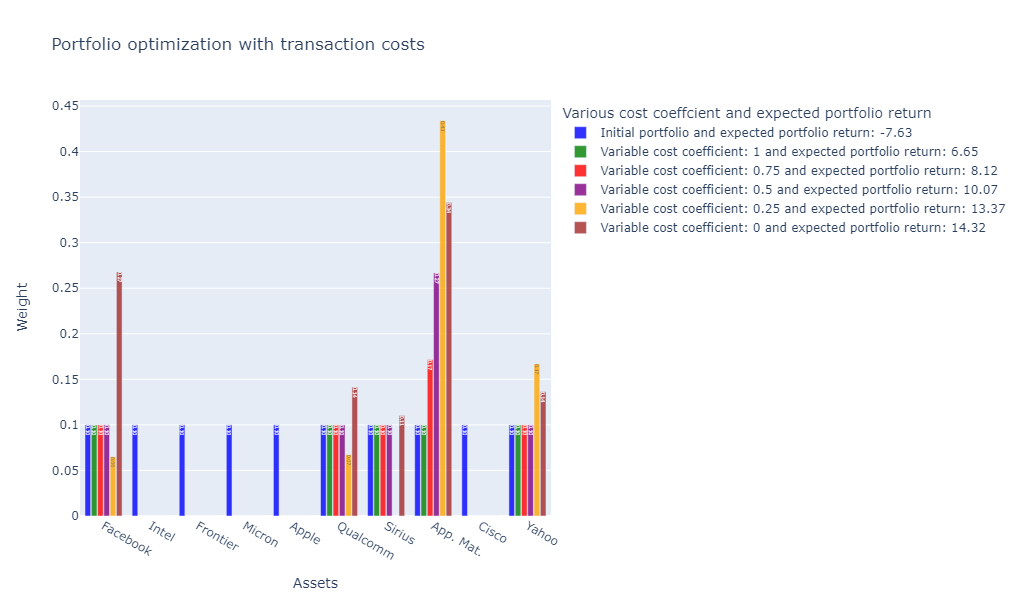

In [15]:
def draw_figures_with_transactions(models, V_list, assets_names, title_name):
    fig = go.Figure()
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']  

    selected_assets = [assets_names[j] for j in range(nb_assets)]

    initial_portfolio = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

    fig.add_trace(go.Bar(
            x=selected_assets,
            y= initial_portfolio,
            name='Initial portfolio and expected portfolio return: -7.63',
            text=[f'{weight:.2f}' for weight in initial_portfolio],
            textposition='auto',
            marker_color=colors[0],
            opacity=0.8,
        ))

    for i, model in enumerate(models):
        portfolio_weights = [pyo.value(model.w[j]) for j in model.N]
        
        fig.add_trace(go.Bar(
            x=selected_assets,
            y=portfolio_weights,
            name=f'Variable cost coefficient: {V_list[i][0]} and expected portfolio return: {round(model.objective(),2)}',
            text=[f'{weight:.2f}' for weight in portfolio_weights],
            textposition='auto',
            marker_color=colors[(i+1) % len(colors)],
            opacity=0.8,
        ))

    fig.update_layout(
        title= title_name,
        xaxis_title='Assets',
        yaxis_title='Weight',
        xaxis=dict(
            tickmode='array',
            tickvals=selected_assets,
            ticktext=[assets_names[j] for j in model.N]  
        ),
        bargap=0.2,  
        bargroupgap=0.1,
        barmode='group', 
        legend_title_text='Various cost coeffcient and expected portfolio return',  
    )

    fig.update_layout(autosize=False, width=1024, height=600)    
    fig.show("png")

draw_figures_with_transactions(models_transaction_costs, V_list, assets_names, "Portfolio optimization with transaction costs")

When transaction costs are taken into account, assets with negative expected returns are removed from the portfolio because the costs associated with trading prevent extensive diversification, making it impractical to include assets that do not contribute positively to the portfolio's overall return. However, if we lower $\Gamma$ , these assets might still be used, as in our example where the variance limit remains high, allowing for their inclusion despite their negative expected returns

# Optimizing portfolios with a large number of assets

In this section, we will test our baseline model with a large number of assets. Despite the increased complexity, we expect to successfully solve the optimization problem using Knitro. By scaling up the number of assets, we aim to demonstrate the robustness and efficiency of our model in handling more extensive portfolios (data is taken from  the top 100 companies listed on the Australian Securities Exchange (ASX)).

## Input data

In [16]:
import pandas as pd 

nb_assets = 100

data_cov_matrix = pd.read_csv('sigma_example.csv')
print(data_cov_matrix)
cov_matrix = data_cov_matrix.values.tolist()

data_expected_returns = pd.read_csv('mu_example.csv')
print(data_expected_returns)
expected_returns = data_expected_returns.squeeze().tolist()

# Like in the first section, we vary the desired return 
desired_returns = [5.0, 7.5, 10.0, 15.0]

data_assets_name = pd.read_csv('names.csv')
assets_names = data_assets_name.squeeze().tolist()

           0         1         2         3         4         5         6  \
0   2.534536  0.047356  0.333075  0.471132  1.125881  0.178098  0.355739   
1   0.047356  0.858942  0.510742  0.825108  0.458187  0.646647  0.352422   
2   0.333075  0.510742  3.991906  1.778789  1.167146  1.545083  0.353567   
3   0.471132  0.825108  1.778789  2.427180  1.437683  1.336803  0.876136   
4   1.125881  0.458187  1.167146  1.437683  3.722347  1.044947  0.626953   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.118763  0.956775  3.275828  2.440533  1.366173  1.810132  0.523715   
96  0.234778  0.307864  0.047807  0.557954  0.457672  0.362358  0.252096   
97  0.128372  0.773043  2.452065  1.905568  1.235017  1.493521  0.827747   
98 -0.373046  0.567859  2.184141  1.309281  2.529939  1.386597  0.453257   
99  0.278282  0.468650  1.890667  1.177265  1.009143  0.823746 -0.094318   

           7         8         9  ...        90        91        92        93  \
0   0.

## Resolution

In [17]:
# Resolution with new inputs 
models = []
solver = pyo.SolverFactory('knitroampl')

for desired_return in desired_returns:
    model = build_model(nb_assets, expected_returns, cov_matrix, desired_return)
    results = solver.solve(model, tee=True)
    models.append(model)


Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

Knitro presolve eliminated 0 variables and 99 constraints.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a convex QP.
Knitro running advanced initialization strategy specified by initpt_strategy.

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Minimize
Objective type:  quadratic
Number of variables:                                100 (         100)
    bounded below only:                             100 (         100)
    bounded above only:                               0 (           0)
    bounded below and above:                          0 (           0)
    fixed:                                            0 (           0)
    free:                                             0 (           0)
Nu

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

Knitro presolve eliminated 0 variables and 99 constraints.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a convex QP.
Knitro running advanced initialization strategy specified by initpt_strategy.

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Minimize
Objective type:  quadratic
Number of variables:                                100 (         100)
    bounded below only:                             100 (         100)
    bounded above only:                               0 (           0)
    bounded below and above:                          0 (           0)
    fixed:                                            0 (           0)
    free:                                             0 (           0)
N

## Visualization of chosen assets

In [18]:
def draw_figures_ha(models, desired_returns, assets_names, title_name):
    fig = go.Figure()
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink'] 

    for i, model in enumerate(models):
        portfolio_weights = [pyo.value(model.w[j]) for j in model.N if model.w[j]() > 0.05]
        selected_assets = [assets_names[j] for j in model.N if model.w[j]() > 0.05]
        
        fig.add_trace(go.Bar(
            x=selected_assets,
            y=portfolio_weights,
            name=f'Desired Return: {desired_returns[i]} and Total Variance: {round(model.objective(),2)}',
            text=[f'{weight:.2f}' for weight in portfolio_weights],
            textposition='auto',
            marker_color=colors[i % len(colors)],
            opacity=0.8,
        ))

    fig.update_layout(
        title= title_name,
        xaxis_title='Assets',
        yaxis_title='Weight',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(len(assets_names))),  
            ticktext=selected_assets  
        ),
        bargap=0.2,  
        bargroupgap=0.1,
        barmode='group', 
        legend_title_text='Desired Returns and corresponding Total Variance ',  
    )

    fig.update_layout(autosize=False, width=1024, height=600)
    
    fig.show("png")

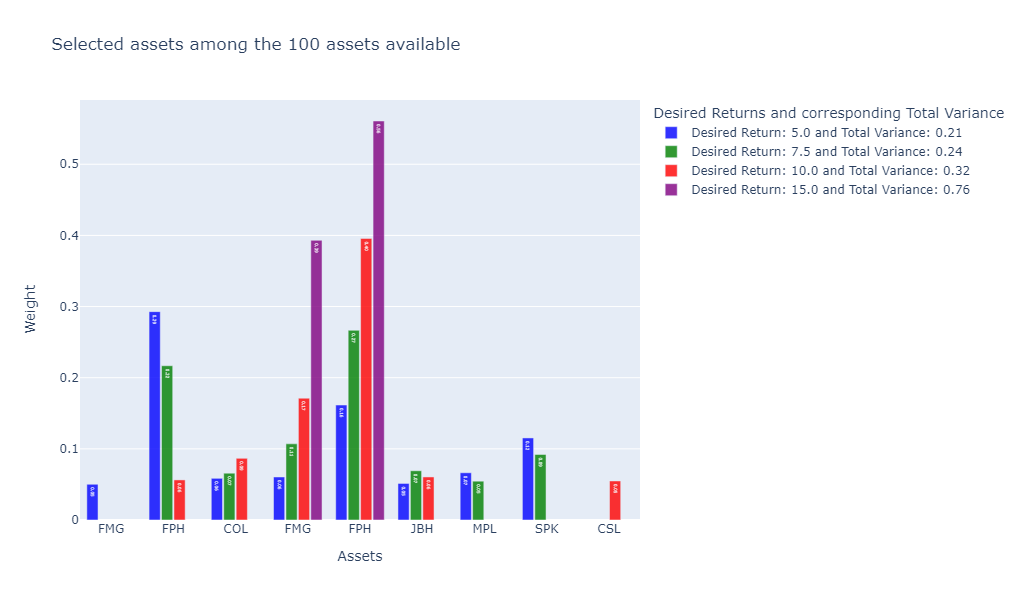

In [19]:
draw_figures_ha(models, desired_returns, assets_names, 'Selected assets among the 100 assets available')

As the figure shows, at most 10 assets are selected to minimize the variance for these desired returns. 